In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np
import torch as pt
import torch.nn as nn
from physics import * # V_step(), angel_diff(), to_tensor(), to_lambda()
from multi_optimizer import * # multi_loss_fun(), get_time_forcing(), compute_multi_path_autograd(), optimizeMultiPath()
from multi_plotter import * # cat_ts(), cat_F(), color_map(), plot_multi_traj(), plot_multi_forcing()

### One segment path (no checkpoints)

In [2]:
# og path
v0 = v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])

n_steps = pt.tensor([32])

dt_max = 0.25
t_final = n_steps.item()*dt_max

F_logits = [nn.Parameter(pt.zeros(n_steps[i], 3)) for i in range(n_steps.shape[0])]

print(f'Start: {v0.detach()}\n' +
      f'Target: {target}\n'
    )

F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs = optimizeMultiPath(v0, target, F_logits,
                                                                               reverse_rate=0,
                                                                               iters=1000)

Start: tensor([0.0000, 0.0000, 0.2000, 1.0000, 1.0000, 0.0000])
Target: tensor([ 5.6807,  2.5029, -1.8625,  2.3750, -1.7500])

Iteration 50, Mean Position Dist: 1.220,  End Time: 4.021,  L2: 0.302,  Reverse Loss: 0.000
Iteration 100, Mean Position Dist: 0.301,  End Time: 4.359,  L2: 0.326,  Reverse Loss: 0.000
Iteration 150, Mean Position Dist: 0.246,  End Time: 4.460,  L2: 0.334,  Reverse Loss: 0.000
Iteration 200, Mean Position Dist: 0.199,  End Time: 4.458,  L2: 0.340,  Reverse Loss: 0.000
Iteration 250, Mean Position Dist: 0.098,  End Time: 4.479,  L2: 0.348,  Reverse Loss: 0.000
Iteration 300, Mean Position Dist: 0.029,  End Time: 4.486,  L2: 0.368,  Reverse Loss: 0.000
Iteration 350, Mean Position Dist: 0.020,  End Time: 4.459,  L2: 0.391,  Reverse Loss: 0.000
Iteration 400, Mean Position Dist: 0.024,  End Time: 4.429,  L2: 0.413,  Reverse Loss: 0.000
Iteration 450, Mean Position Dist: 0.028,  End Time: 4.402,  L2: 0.433,  Reverse Loss: 0.000
Iteration 500, Mean Position Dist: 0.

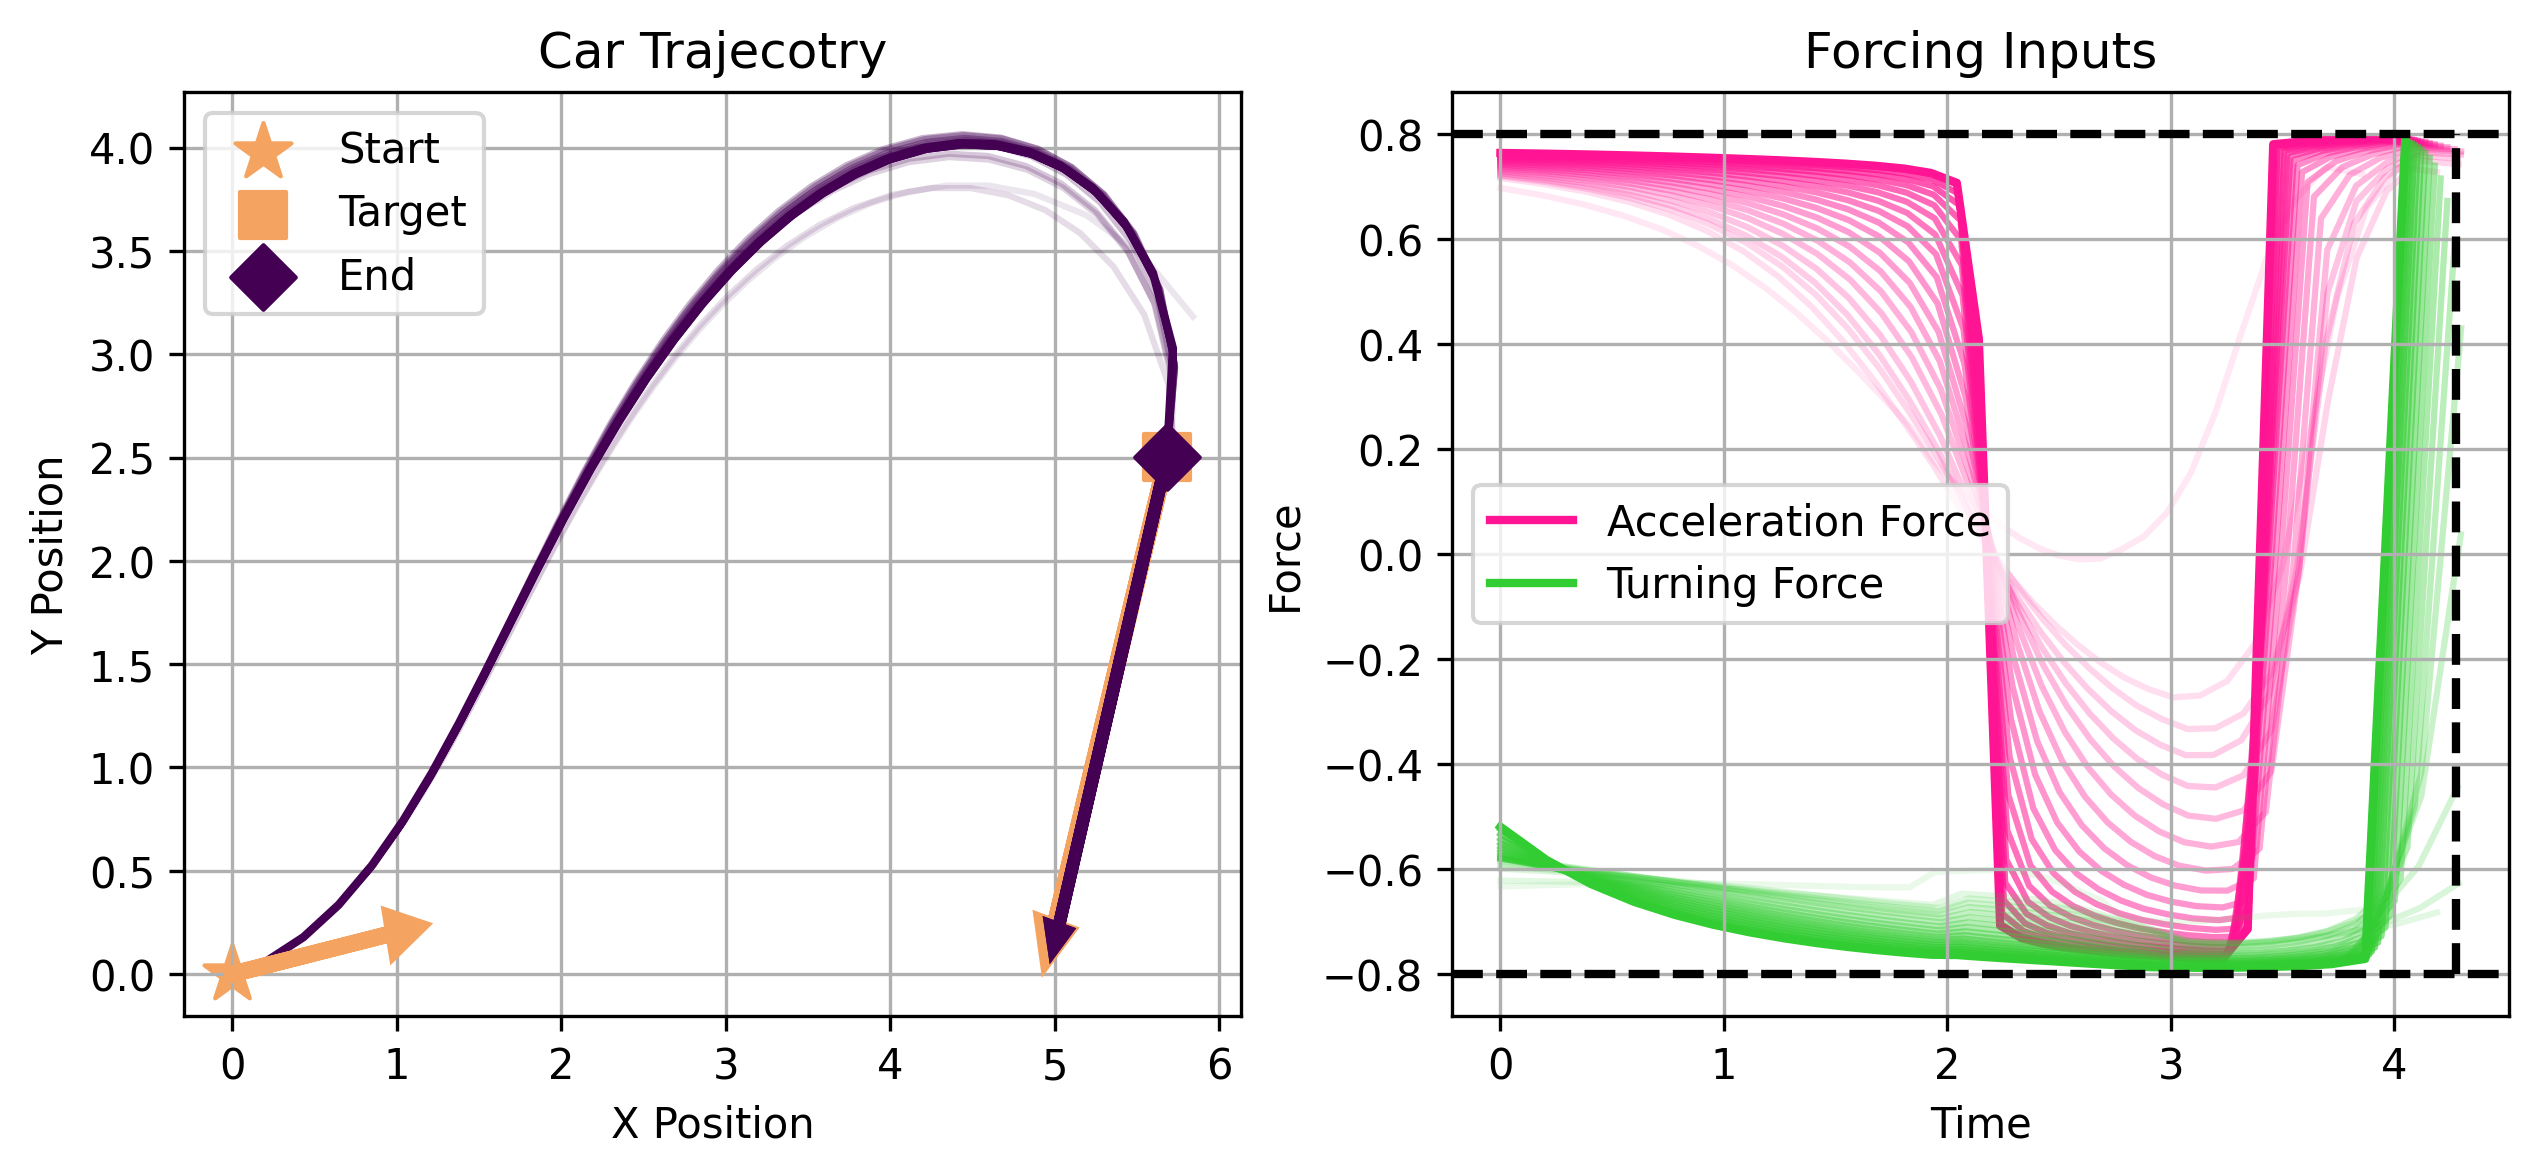

In [3]:
ts_cat = cat_ts(ts_mat)
F_cat = cat_F(F_true)

#fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,16))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=300)

plot_multi_traj(V_mat, target, ax=ax1)
plot_multi_forcing(F_cat, ts_cat, n_steps, ax=ax2)
plt.show()

### Two segment path (one checkpoint)

In [4]:
v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])
checkpoint_2d = pt.tensor([[7, 5]])
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])
n_steps = pt.tensor([32, 32])

checkpoint_dof_init = pt.tensor([[np.pi/2, 1,0.5]])

checkpoint_dof = nn.Parameter(checkpoint_dof_init.clone())

F_logits = [nn.Parameter(pt.zeros(n_steps[i], 3)) for i in range(n_steps.shape[0])]

print(f'Start: {v0.detach()}\n' +
      f'Checkpoint Guess: {pt.cat([checkpoint_2d, checkpoint_dof.detach()], dim=1)}\n'+
      f'Target: {target}\n'
    )

F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs = optimizeMultiPath(v0, target, F_logits,
                                                                               checkpoint_2d=checkpoint_2d,
                                                                               checkpoint_dof=checkpoint_dof,
                                                                               iters=1000)

segment_start = pt.cat([checkpoint_2d, checkpoint_dof], dim=1)
segment_end = pt.tensor([V_mat[-1][i][-1:].tolist() for i in range(len(V_mat[-1])-1)]).squeeze(dim=1)

segment_diff = segment_start-segment_end

segment_diff[:,2] = angle_diff(segment_start[:,2], segment_end[:,2])

print(f'Position Differences:\n{segment_diff}')

Start: tensor([0.0000, 0.0000, 0.2000, 1.0000, 1.0000, 0.0000])
Checkpoint Guess: tensor([[7.0000, 5.0000, 1.5708, 1.0000, 0.5000]])
Target: tensor([ 5.6807,  2.5029, -1.8625,  2.3750, -1.7500])

Iteration 50, Mean Position Dist: 1.570,  End Time: 9.720,  L2: 0.196,  Reverse Loss: 0.017
Iteration 100, Mean Position Dist: 0.541,  End Time: 11.109,  L2: 0.251,  Reverse Loss: 0.009
Iteration 150, Mean Position Dist: 0.473,  End Time: 11.048,  L2: 0.249,  Reverse Loss: 0.004
Iteration 200, Mean Position Dist: 0.411,  End Time: 11.134,  L2: 0.255,  Reverse Loss: 0.002
Iteration 250, Mean Position Dist: 0.344,  End Time: 11.260,  L2: 0.269,  Reverse Loss: 0.002
Iteration 300, Mean Position Dist: 0.418,  End Time: 11.377,  L2: 0.290,  Reverse Loss: 0.002
Iteration 350, Mean Position Dist: 0.247,  End Time: 11.446,  L2: 0.313,  Reverse Loss: 0.002
Iteration 400, Mean Position Dist: 0.208,  End Time: 11.534,  L2: 0.334,  Reverse Loss: 0.003
Iteration 450, Mean Position Dist: 0.180,  End Time: 1

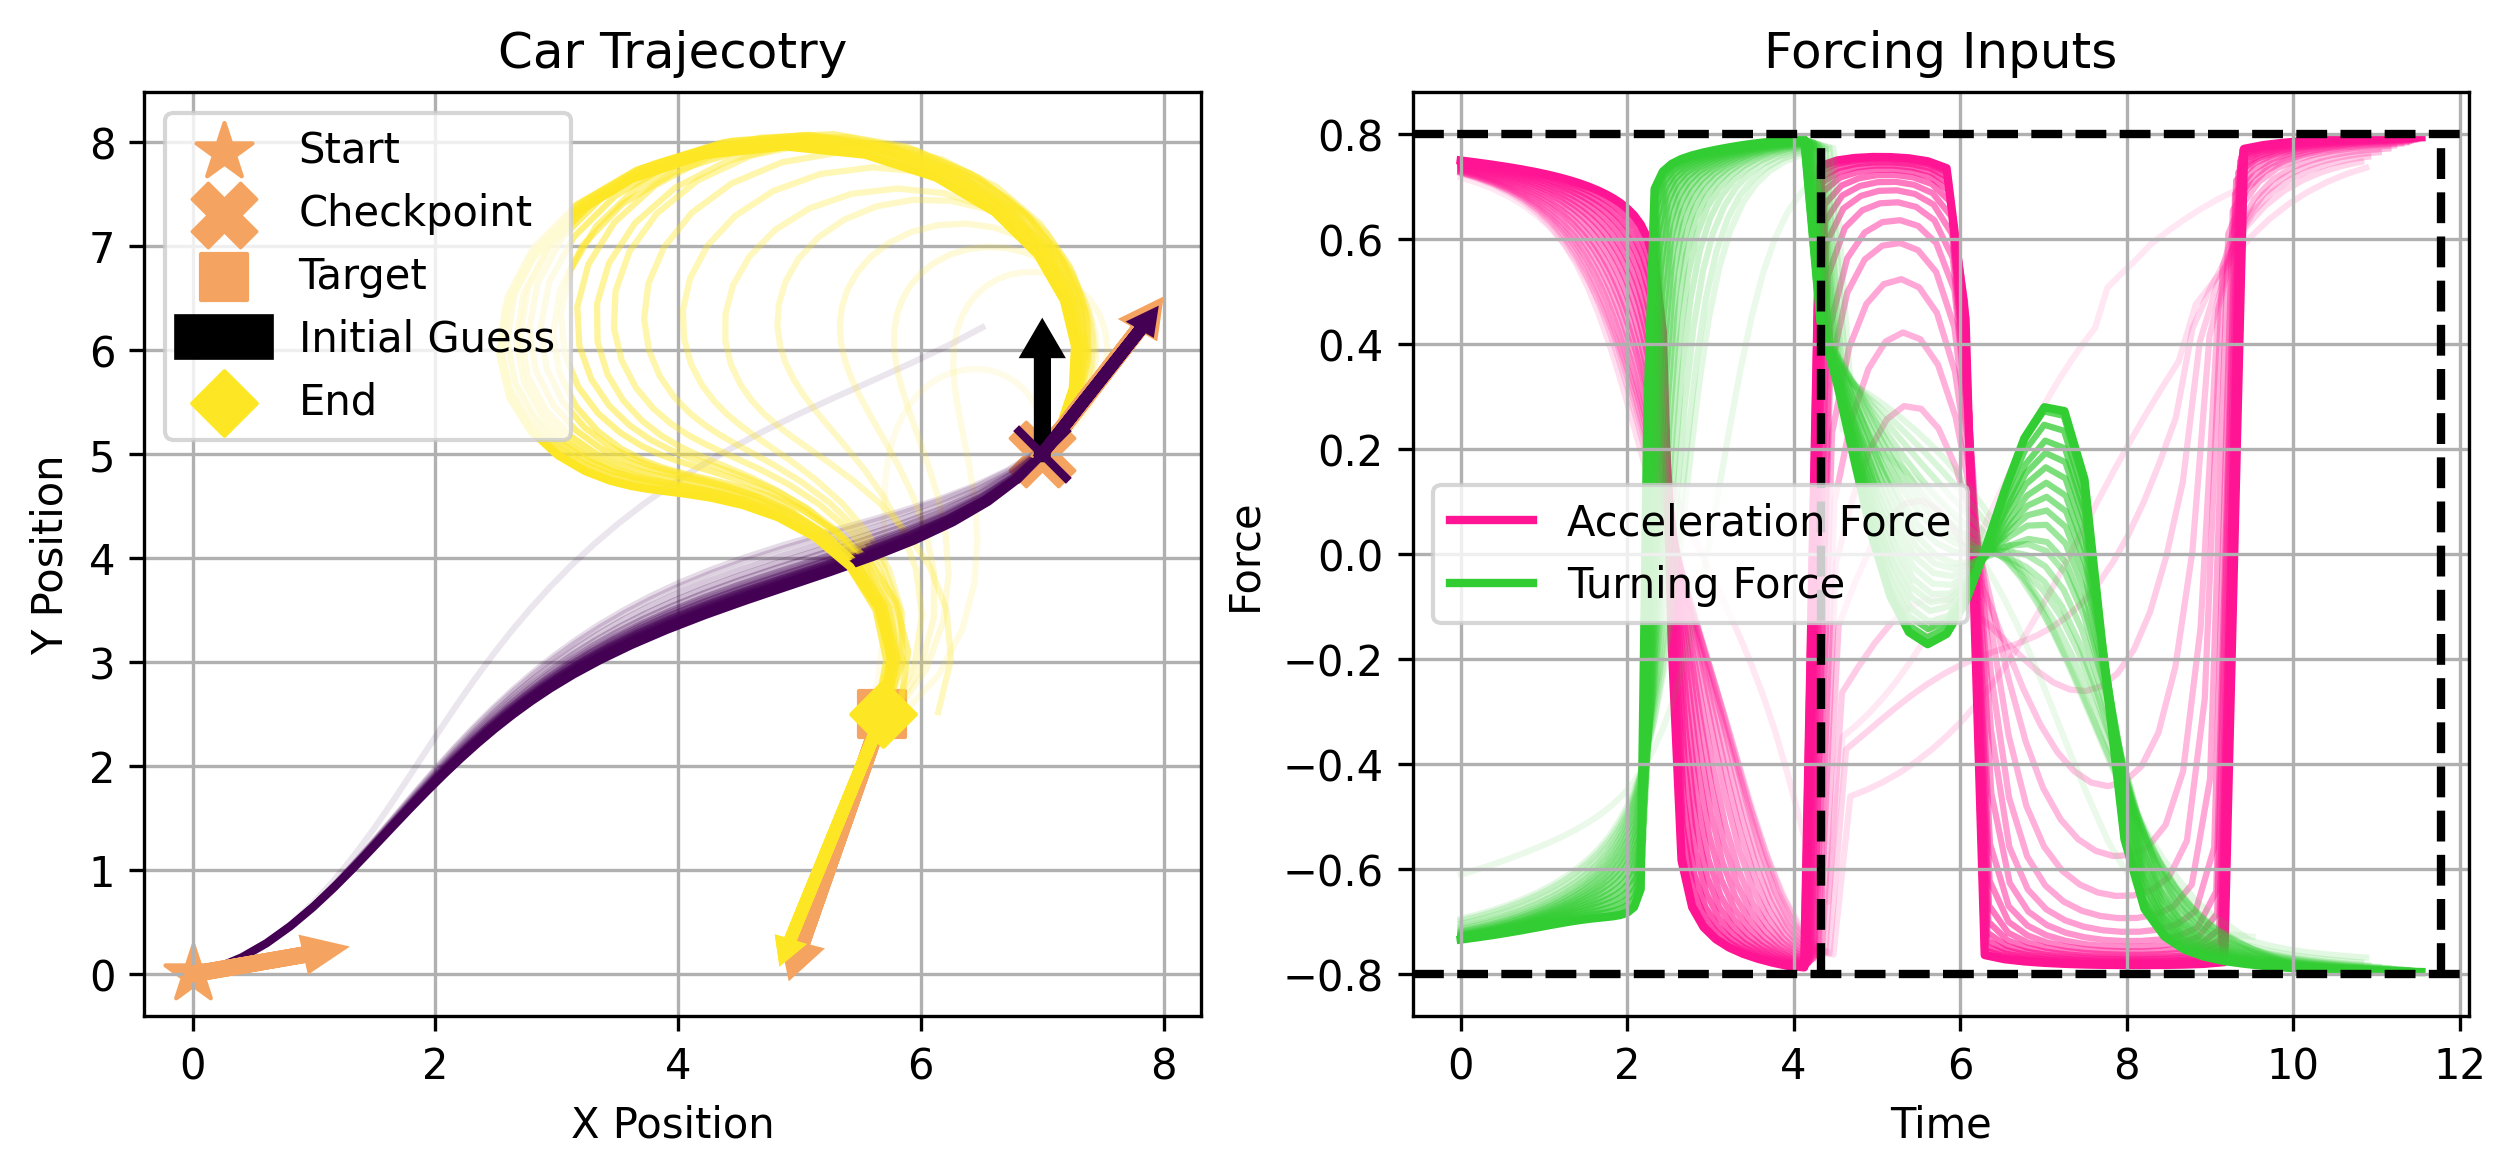

In [5]:
ts_cat = cat_ts(ts_mat)
F_cat = cat_F(F_true)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=300)

plot_multi_traj(V_mat, target, checkpoint_2d=checkpoint_2d, checkpoint_dof=checkpoint_dof, dof_init=checkpoint_dof_init, ax=ax1)
plot_multi_forcing(F_cat, ts_cat, n_steps, ax=ax2)
plt.show()

### Three segment paths (two checkpoints)

In [6]:
n_steps = pt.tensor([32, 32, 16])

dt_max = 0.25

tf = n_steps.sum()*dt_max

v0 = pt.tensor([0, 0, -0.2, 0.5, 0, 0])
checkpoint_2d = pt.tensor([[4, -4],
                           [8, 4]])
target = pt.tensor([11, 8, np.pi/8, 2.5, -0.2])

checkpoint_dof_init = pt.tensor([[-np.pi/8, 0.5, 0],
                                 [3*np.pi/8, 0.5, -0.5]])

F_logits = [nn.Parameter(pt.zeros(n_steps[i], 3)) for i in range(n_steps.shape[0])]
checkpoint_dof = nn.Parameter(checkpoint_dof_init.clone()) 


print(f'Start: {v0.detach()}\n' +
      f'Checkpoint Guess: {pt.cat([checkpoint_2d, checkpoint_dof.detach()], dim=1)}\n'+
      f'Target: {target}\n'
    )

F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs = optimizeMultiPath(v0, target, F_logits,
                                                                               checkpoint_2d=checkpoint_2d,
                                                                               checkpoint_dof=checkpoint_dof,
                                                                               reverse_rate=0,
                                                                               iters=1000)

Start: tensor([ 0.0000,  0.0000, -0.2000,  0.5000,  0.0000,  0.0000])
Checkpoint Guess: tensor([[ 4.0000, -4.0000, -0.3927,  0.5000,  0.0000],
        [ 8.0000,  4.0000,  1.1781,  0.5000, -0.5000]])
Target: tensor([11.0000,  8.0000,  0.3927,  2.5000, -0.2000])

Iteration 50, Mean Position Dist: 0.526,  End Time: 11.863,  L2: 0.094,  Reverse Loss: 0.005
Iteration 100, Mean Position Dist: 0.145,  End Time: 12.213,  L2: 0.107,  Reverse Loss: 0.006
Iteration 150, Mean Position Dist: 0.055,  End Time: 12.355,  L2: 0.124,  Reverse Loss: 0.006
Iteration 200, Mean Position Dist: 0.051,  End Time: 12.296,  L2: 0.144,  Reverse Loss: 0.006
Iteration 250, Mean Position Dist: 0.049,  End Time: 12.147,  L2: 0.171,  Reverse Loss: 0.006
Iteration 300, Mean Position Dist: 0.051,  End Time: 11.979,  L2: 0.204,  Reverse Loss: 0.006
Iteration 350, Mean Position Dist: 0.051,  End Time: 11.822,  L2: 0.237,  Reverse Loss: 0.006
Iteration 400, Mean Position Dist: 0.052,  End Time: 11.674,  L2: 0.268,  Reverse

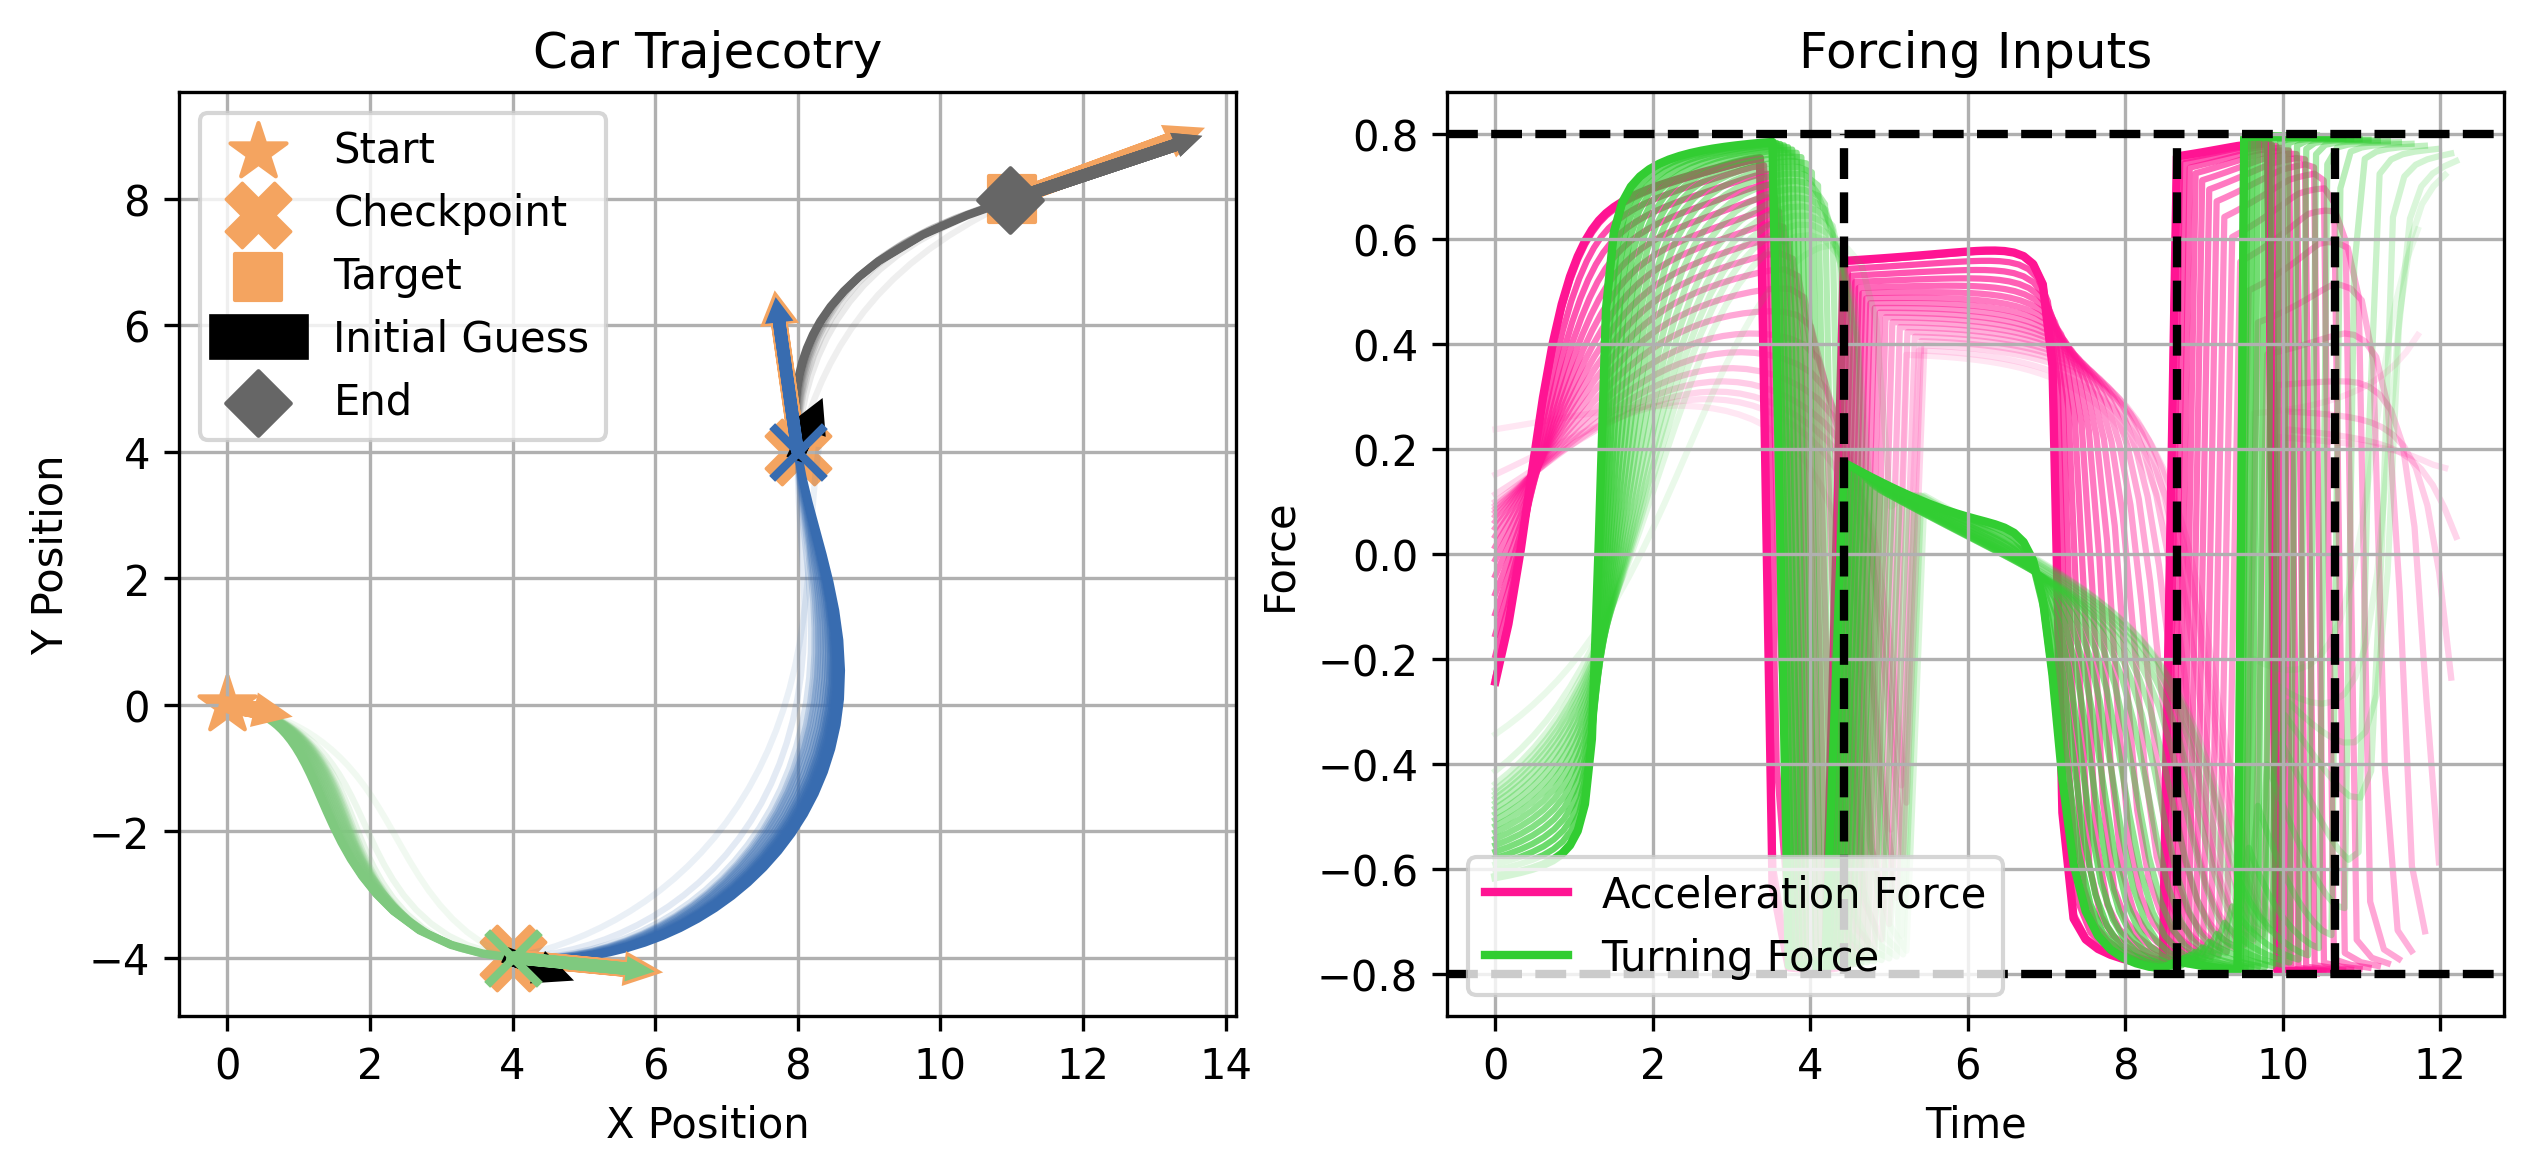

In [7]:
ts_cat = cat_ts(ts_mat)
F_cat = cat_F(F_true)

#fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,16))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=300)

plot_multi_traj(V_mat, target, 
          checkpoint_2d=checkpoint_2d, checkpoint_dof=checkpoint_dof, 
          dof_init=checkpoint_dof_init, ax=ax1, cmap='Accent')
plot_multi_forcing(F_cat, ts_cat, n_steps, ax=ax2)
plt.show()

In [8]:
v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])
checkpoint_2d = pt.tensor([[3,  2],
                           [7, 5]])
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])
n_steps = pt.tensor([32, 32, 32])

checkpoint_dof_init = pt.tensor([[0,1,-0.5],
                                 [np.pi/2, 1,0.5]])

checkpoint_dof = nn.Parameter(checkpoint_dof_init.clone())

F_logits = [nn.Parameter(pt.zeros(n_steps[i], 3)) for i in range(n_steps.shape[0])]

print(f'Start: {v0.detach()}\n' +
      f'Checkpoint Guess: {pt.cat([checkpoint_2d, checkpoint_dof.detach()], dim=1)}\n'+
      f'Target: {target}\n'
    )

F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs = optimizeMultiPath(v0, target, F_logits,
                                                                               checkpoint_2d=checkpoint_2d,
                                                                               checkpoint_dof=checkpoint_dof,
                                                                               #reverse_rate=0,
                                                                               iters=1000)

segment_start = pt.cat([checkpoint_2d, checkpoint_dof], dim=1)
segment_end = pt.tensor([V_mat[-1][i][-1:].tolist() for i in range(len(V_mat[-1])-1)]).squeeze(dim=1)

segment_diff = segment_start-segment_end

segment_diff[:,2] = angle_diff(segment_start[:,2], segment_end[:,2])

print(f'Position Differences:\n{segment_diff}')

Start: tensor([0.0000, 0.0000, 0.2000, 1.0000, 1.0000, 0.0000])
Checkpoint Guess: tensor([[ 3.0000,  2.0000,  0.0000,  1.0000, -0.5000],
        [ 7.0000,  5.0000,  1.5708,  1.0000,  0.5000]])
Target: tensor([ 5.6807,  2.5029, -1.8625,  2.3750, -1.7500])

Iteration 50, Mean Position Dist: 0.797,  End Time: 14.475,  L2: 0.162,  Reverse Loss: 0.022
Iteration 100, Mean Position Dist: 0.443,  End Time: 15.289,  L2: 0.198,  Reverse Loss: 0.047
Iteration 150, Mean Position Dist: 0.365,  End Time: 15.129,  L2: 0.211,  Reverse Loss: 0.033
Iteration 200, Mean Position Dist: 0.298,  End Time: 15.105,  L2: 0.225,  Reverse Loss: 0.022
Iteration 250, Mean Position Dist: 0.238,  End Time: 15.120,  L2: 0.242,  Reverse Loss: 0.016
Iteration 300, Mean Position Dist: 0.188,  End Time: 15.144,  L2: 0.262,  Reverse Loss: 0.014
Iteration 350, Mean Position Dist: 0.149,  End Time: 15.155,  L2: 0.284,  Reverse Loss: 0.012
Iteration 400, Mean Position Dist: 0.135,  End Time: 15.119,  L2: 0.307,  Reverse Loss:

In [9]:
# speeds of final path at each timestep
pt.cat([V_mat[-1][0]] + [V_mat[-1][i][1:] for i in range(1, len(V_mat[-1]))])[:,3]

tensor([1.0000, 1.1818, 1.3624, 1.5416, 1.7190, 1.8922, 1.7714, 1.6641, 1.5630,
        1.4644, 1.3668, 1.2695, 1.1724, 1.0754, 0.9781, 0.8802, 0.7804, 0.6770,
        0.5676, 0.4523, 0.4037, 0.5130, 0.6209, 0.7333, 0.8572, 0.9950, 1.1454,
        1.3066, 1.4782, 1.6552, 1.8347, 2.0164, 2.2007, 2.2866, 2.3661, 2.4417,
        2.5133, 2.5809, 2.6444, 2.7037, 2.7588, 2.8097, 2.8563, 2.8980, 2.9323,
        2.9371, 2.8967, 2.8540, 2.8120, 2.7713, 2.7321, 2.6944, 2.6580, 2.6228,
        2.5888, 2.5558, 2.5237, 2.4925, 2.4621, 2.4324, 2.4034, 2.3748, 2.3465,
        2.3186, 2.2921, 2.4592, 2.6274, 2.7942, 2.9570, 3.0816, 2.9075, 2.7314,
        2.5539, 2.3752, 2.1956, 2.0154, 1.8348, 1.6543, 1.4739, 1.2935, 1.1135,
        0.9338, 0.7543, 0.5750, 0.3969, 0.5440, 0.6826, 0.8261, 0.9766, 1.1348,
        1.3054, 1.4788, 1.6540, 1.8302, 2.0068, 2.1837, 2.3612])

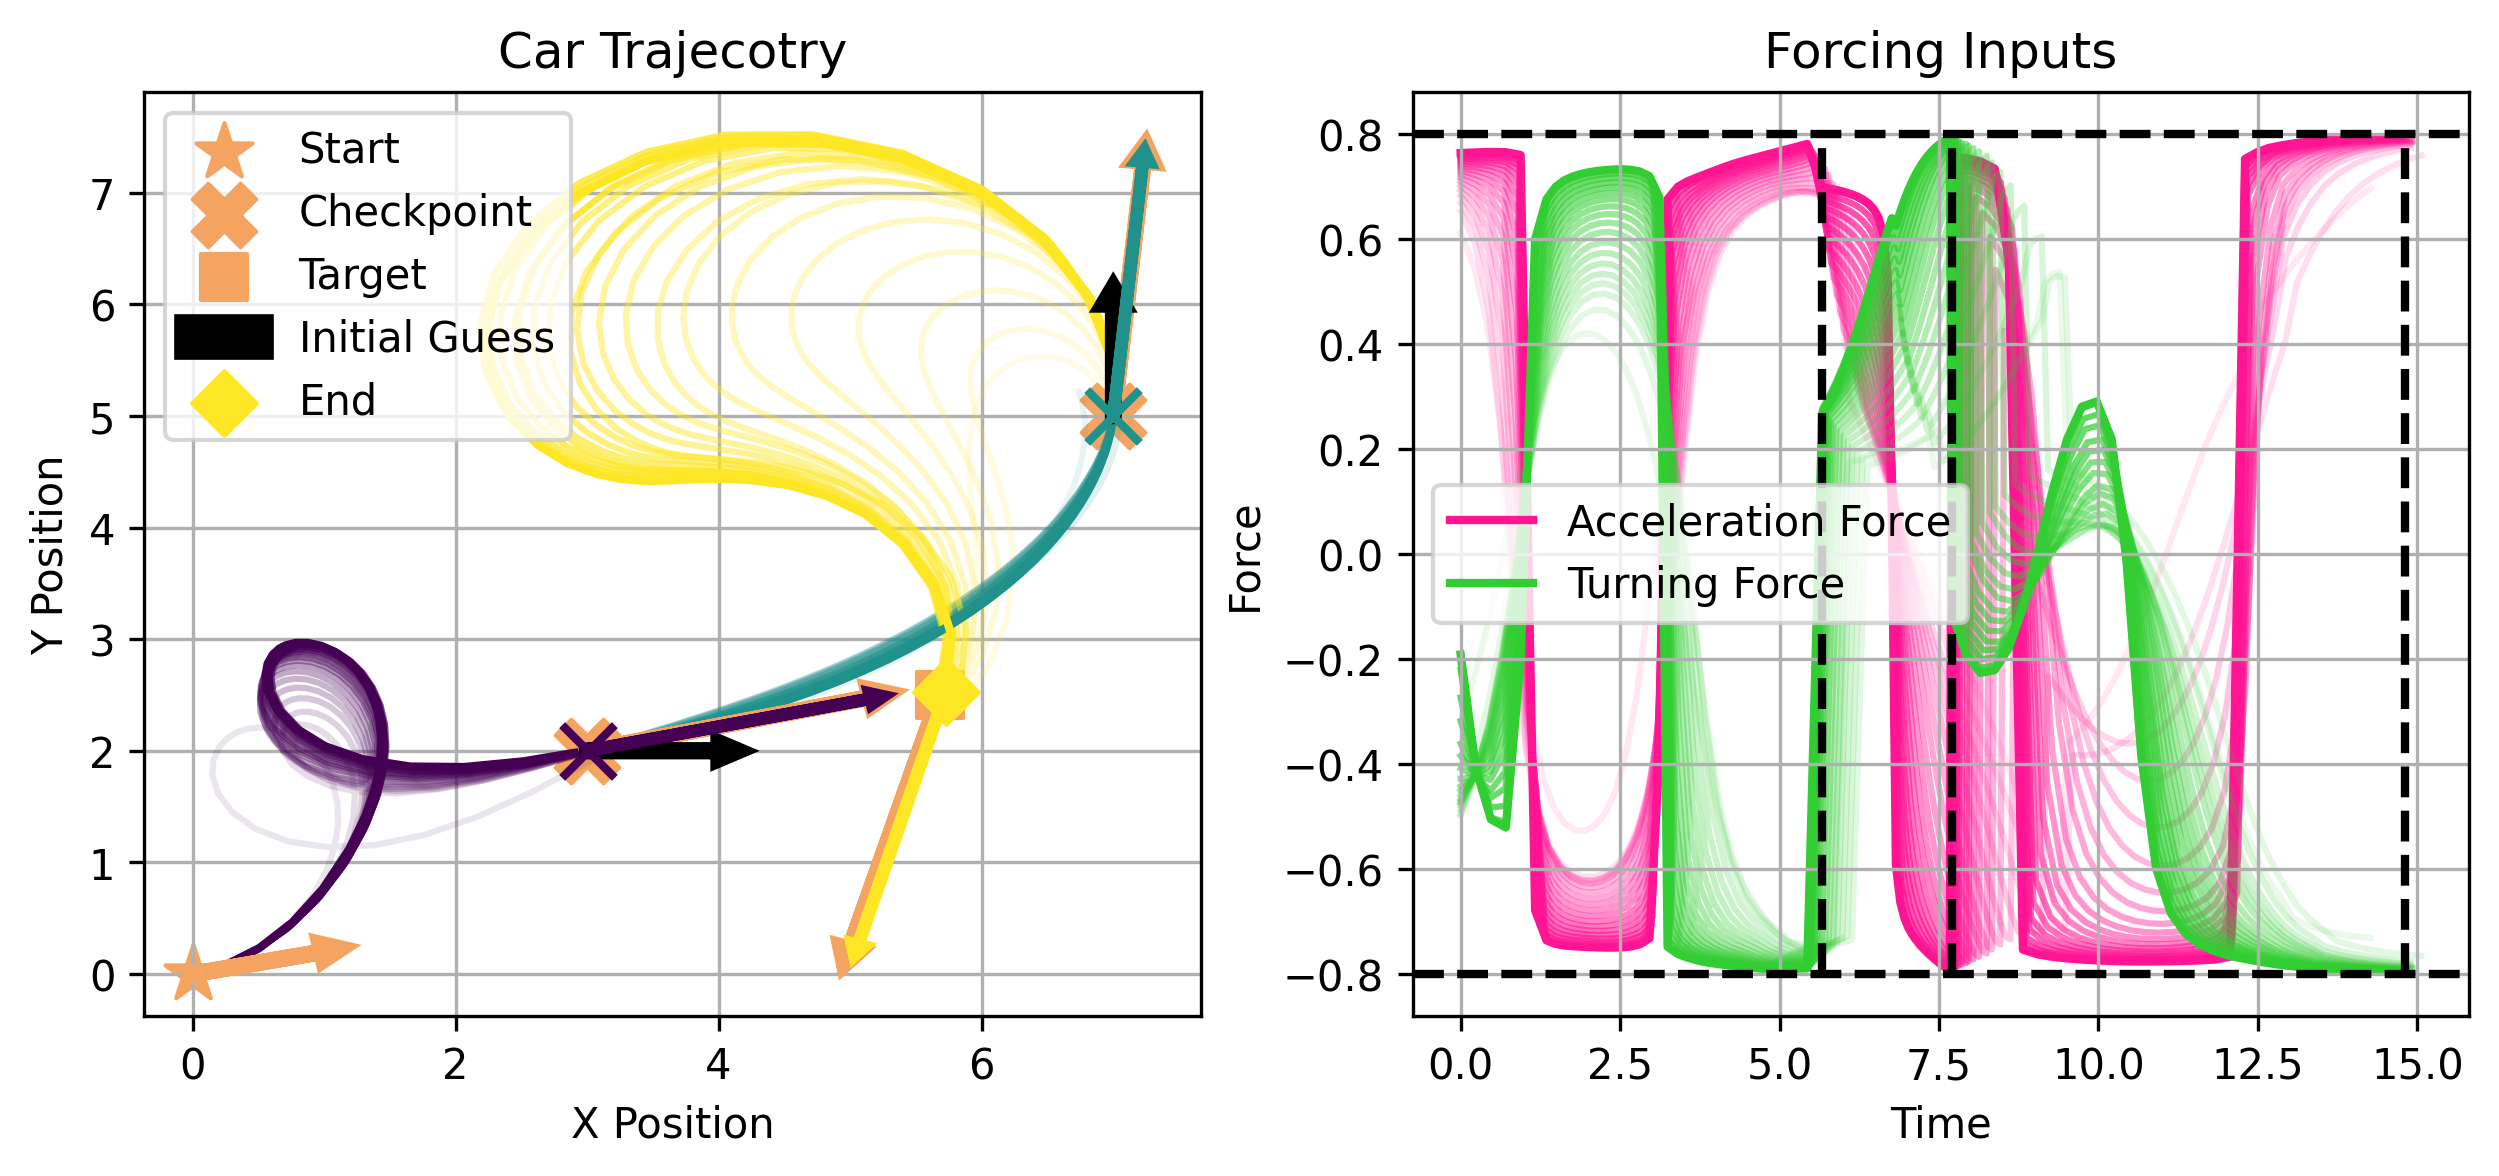

In [10]:
ts_cat = cat_ts(ts_mat)
F_cat = cat_F(F_true)

#fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 16))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=300)

plot_multi_traj(V_mat, target, 
          checkpoint_2d=checkpoint_2d, checkpoint_dof=checkpoint_dof, 
          dof_init=checkpoint_dof_init, ax=ax1)
plot_multi_forcing(F_cat, ts_cat, n_steps, ax=ax2)
plt.show()

### Testing reverse loss

Start: tensor([0.0000, 0.0000, 0.2000, 1.0000, 1.0000, 0.0000])
Target: tensor([ 3.0000,  2.0000,  0.0000,  1.0000, -0.5000])

Iteration 50, Mean Position Dist: 1.407,  End Time: 6.437,  L2: 0.232,  Reverse Loss: 59.056
Iteration 100, Mean Position Dist: 0.420,  End Time: 7.158,  L2: 0.292,  Reverse Loss: 12.993
Iteration 150, Mean Position Dist: 0.256,  End Time: 7.237,  L2: 0.327,  Reverse Loss: 27.715
Iteration 200, Mean Position Dist: 0.175,  End Time: 7.303,  L2: 0.355,  Reverse Loss: 40.713
Iteration 250, Mean Position Dist: 0.127,  End Time: 7.360,  L2: 0.379,  Reverse Loss: 54.119
Iteration 300, Mean Position Dist: 0.096,  End Time: 7.403,  L2: 0.402,  Reverse Loss: 66.332
Iteration 350, Mean Position Dist: 0.075,  End Time: 7.435,  L2: 0.423,  Reverse Loss: 77.004
Iteration 400, Mean Position Dist: 0.061,  End Time: 7.459,  L2: 0.443,  Reverse Loss: 86.106
Iteration 450, Mean Position Dist: 0.053,  End Time: 7.476,  L2: 0.461,  Reverse Loss: 93.791
Iteration 500, Mean Position

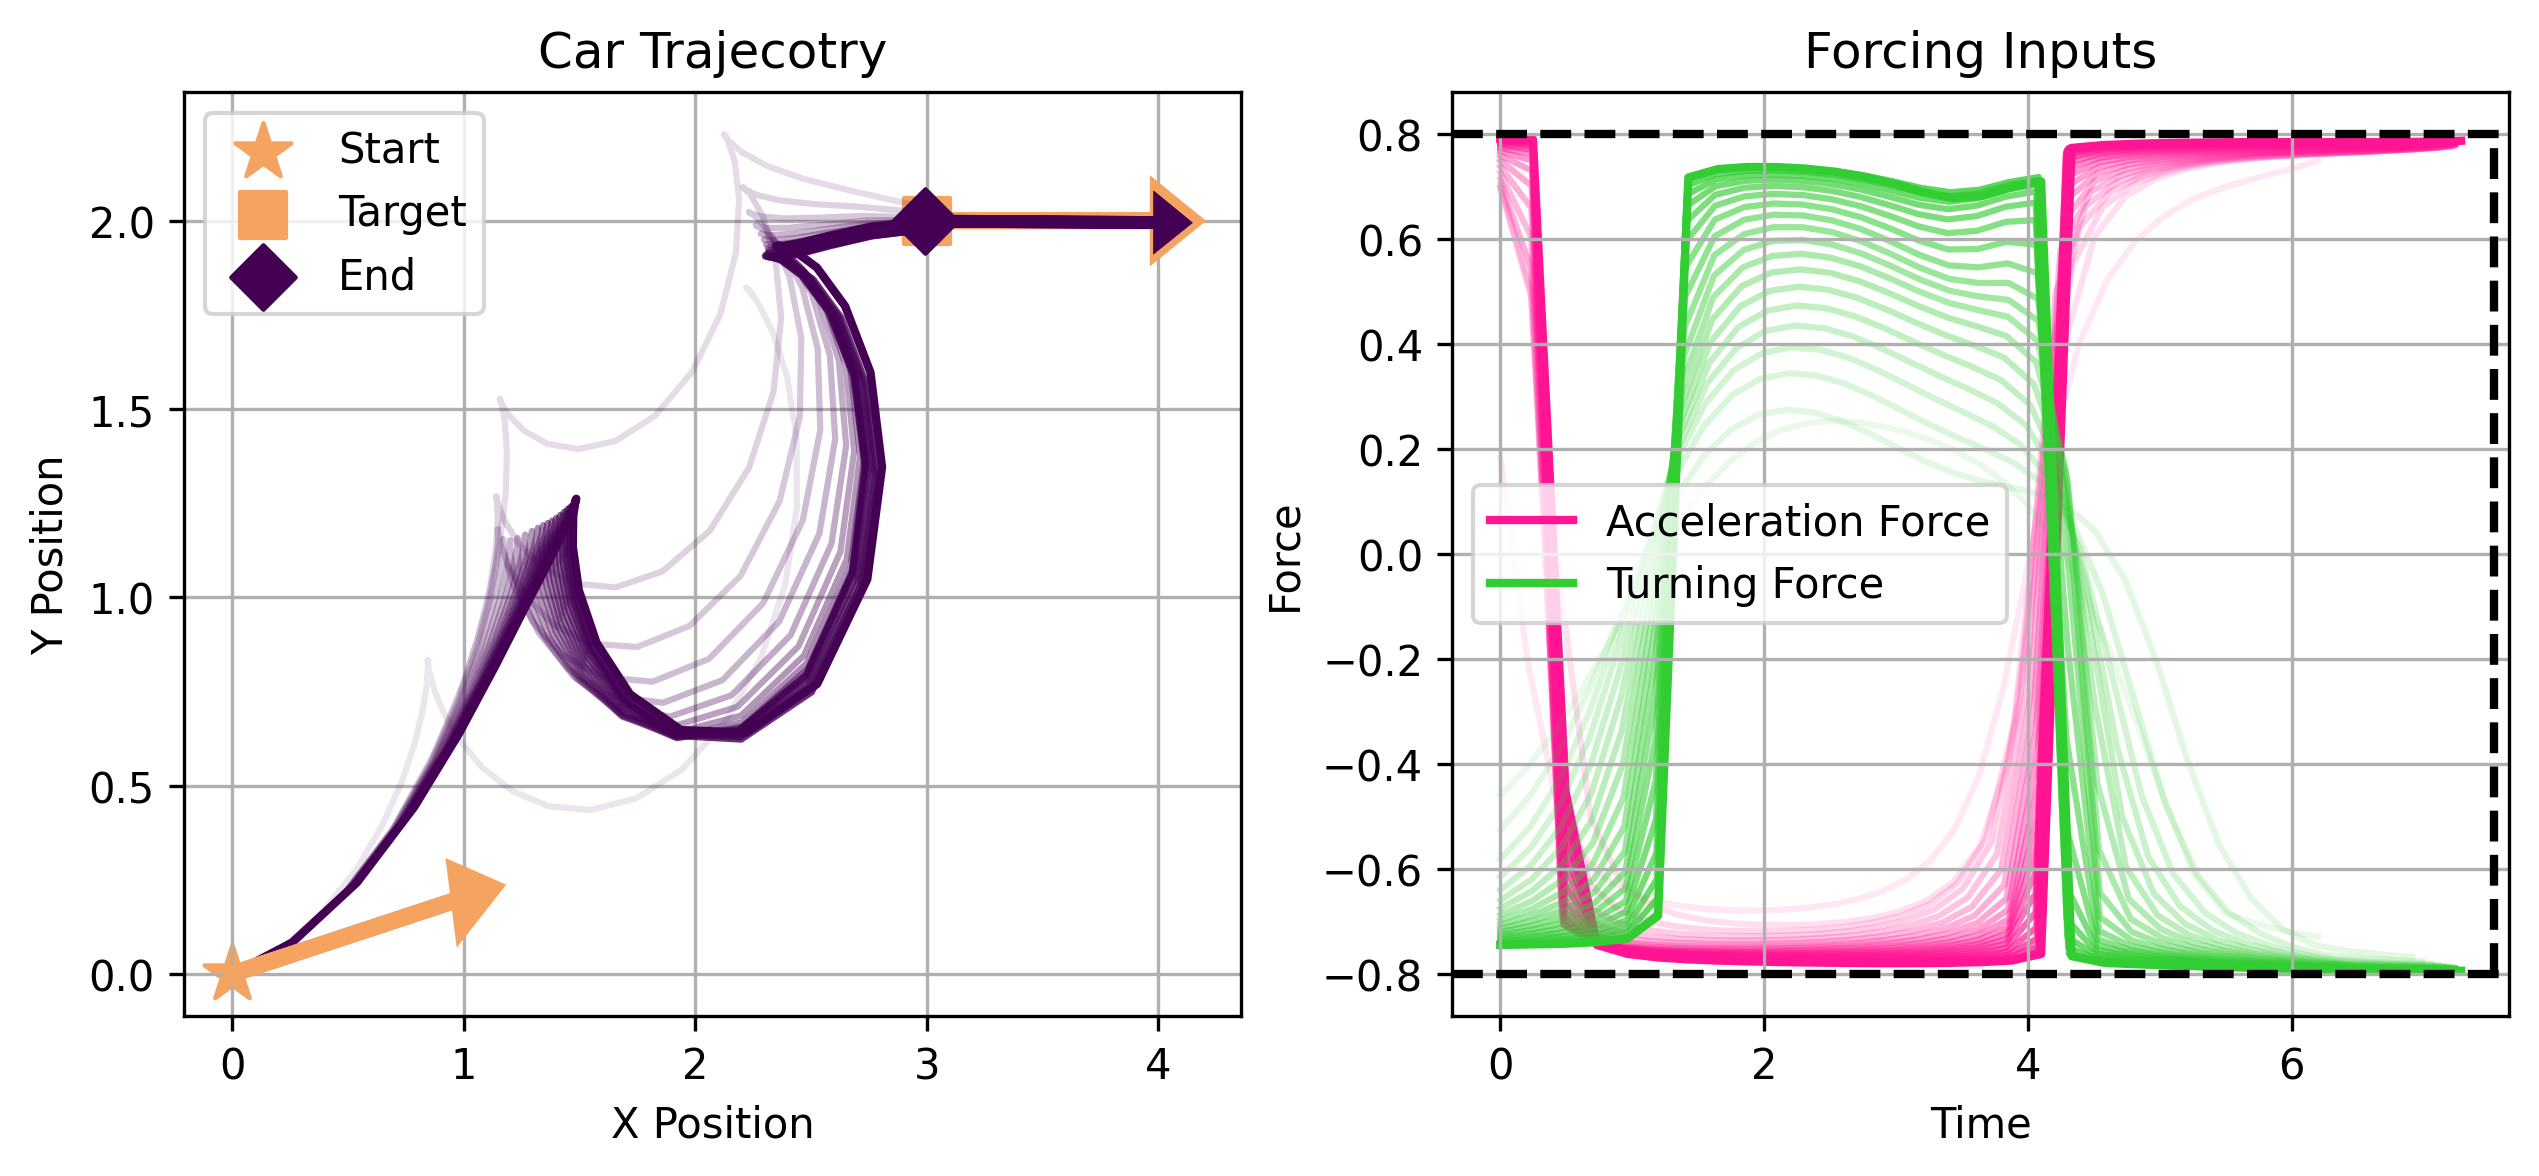

In [11]:
v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])

target = pt.tensor([3, 2, 0,1,-0.5])
n_steps = pt.tensor([32])

F_logits = [nn.Parameter(pt.zeros(n_steps[i], 3)) for i in range(n_steps.shape[0])]

print(f'Start: {v0.detach()}\n' +
      f'Target: {target}\n'
    )

pt.autograd.set_detect_anomaly(False)

F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs = optimizeMultiPath(v0, target, F_logits,
                                                                               reverse_rate=0,
                                                                               iters=1000)

ts_cat = cat_ts(ts_mat)
F_cat = cat_F(F_true)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=300)


plot_multi_traj(V_mat, target, ax=ax1)
plot_multi_forcing(F_cat, ts_cat, n_steps, ax=ax2)
plt.show()

Start: tensor([0.0000, 0.0000, 0.2000, 1.0000, 1.0000, 0.0000])
Target: tensor([ 3.0000,  2.0000,  0.0000,  1.0000, -0.5000])

Iteration 50, Mean Position Dist: 1.109,  End Time: 6.274,  L2: 0.227,  Reverse Loss: 0.157
Iteration 100, Mean Position Dist: 0.551,  End Time: 6.867,  L2: 0.291,  Reverse Loss: 0.344
Iteration 150, Mean Position Dist: 0.215,  End Time: 6.810,  L2: 0.293,  Reverse Loss: 0.139
Iteration 200, Mean Position Dist: 0.107,  End Time: 6.763,  L2: 0.305,  Reverse Loss: 0.072
Iteration 250, Mean Position Dist: 0.071,  End Time: 6.687,  L2: 0.320,  Reverse Loss: 0.050
Iteration 300, Mean Position Dist: 0.054,  End Time: 6.616,  L2: 0.338,  Reverse Loss: 0.041
Iteration 350, Mean Position Dist: 0.046,  End Time: 6.553,  L2: 0.359,  Reverse Loss: 0.036
Iteration 400, Mean Position Dist: 0.044,  End Time: 6.499,  L2: 0.380,  Reverse Loss: 0.034
Iteration 450, Mean Position Dist: 0.042,  End Time: 6.454,  L2: 0.401,  Reverse Loss: 0.033
Iteration 500, Mean Position Dist: 0.

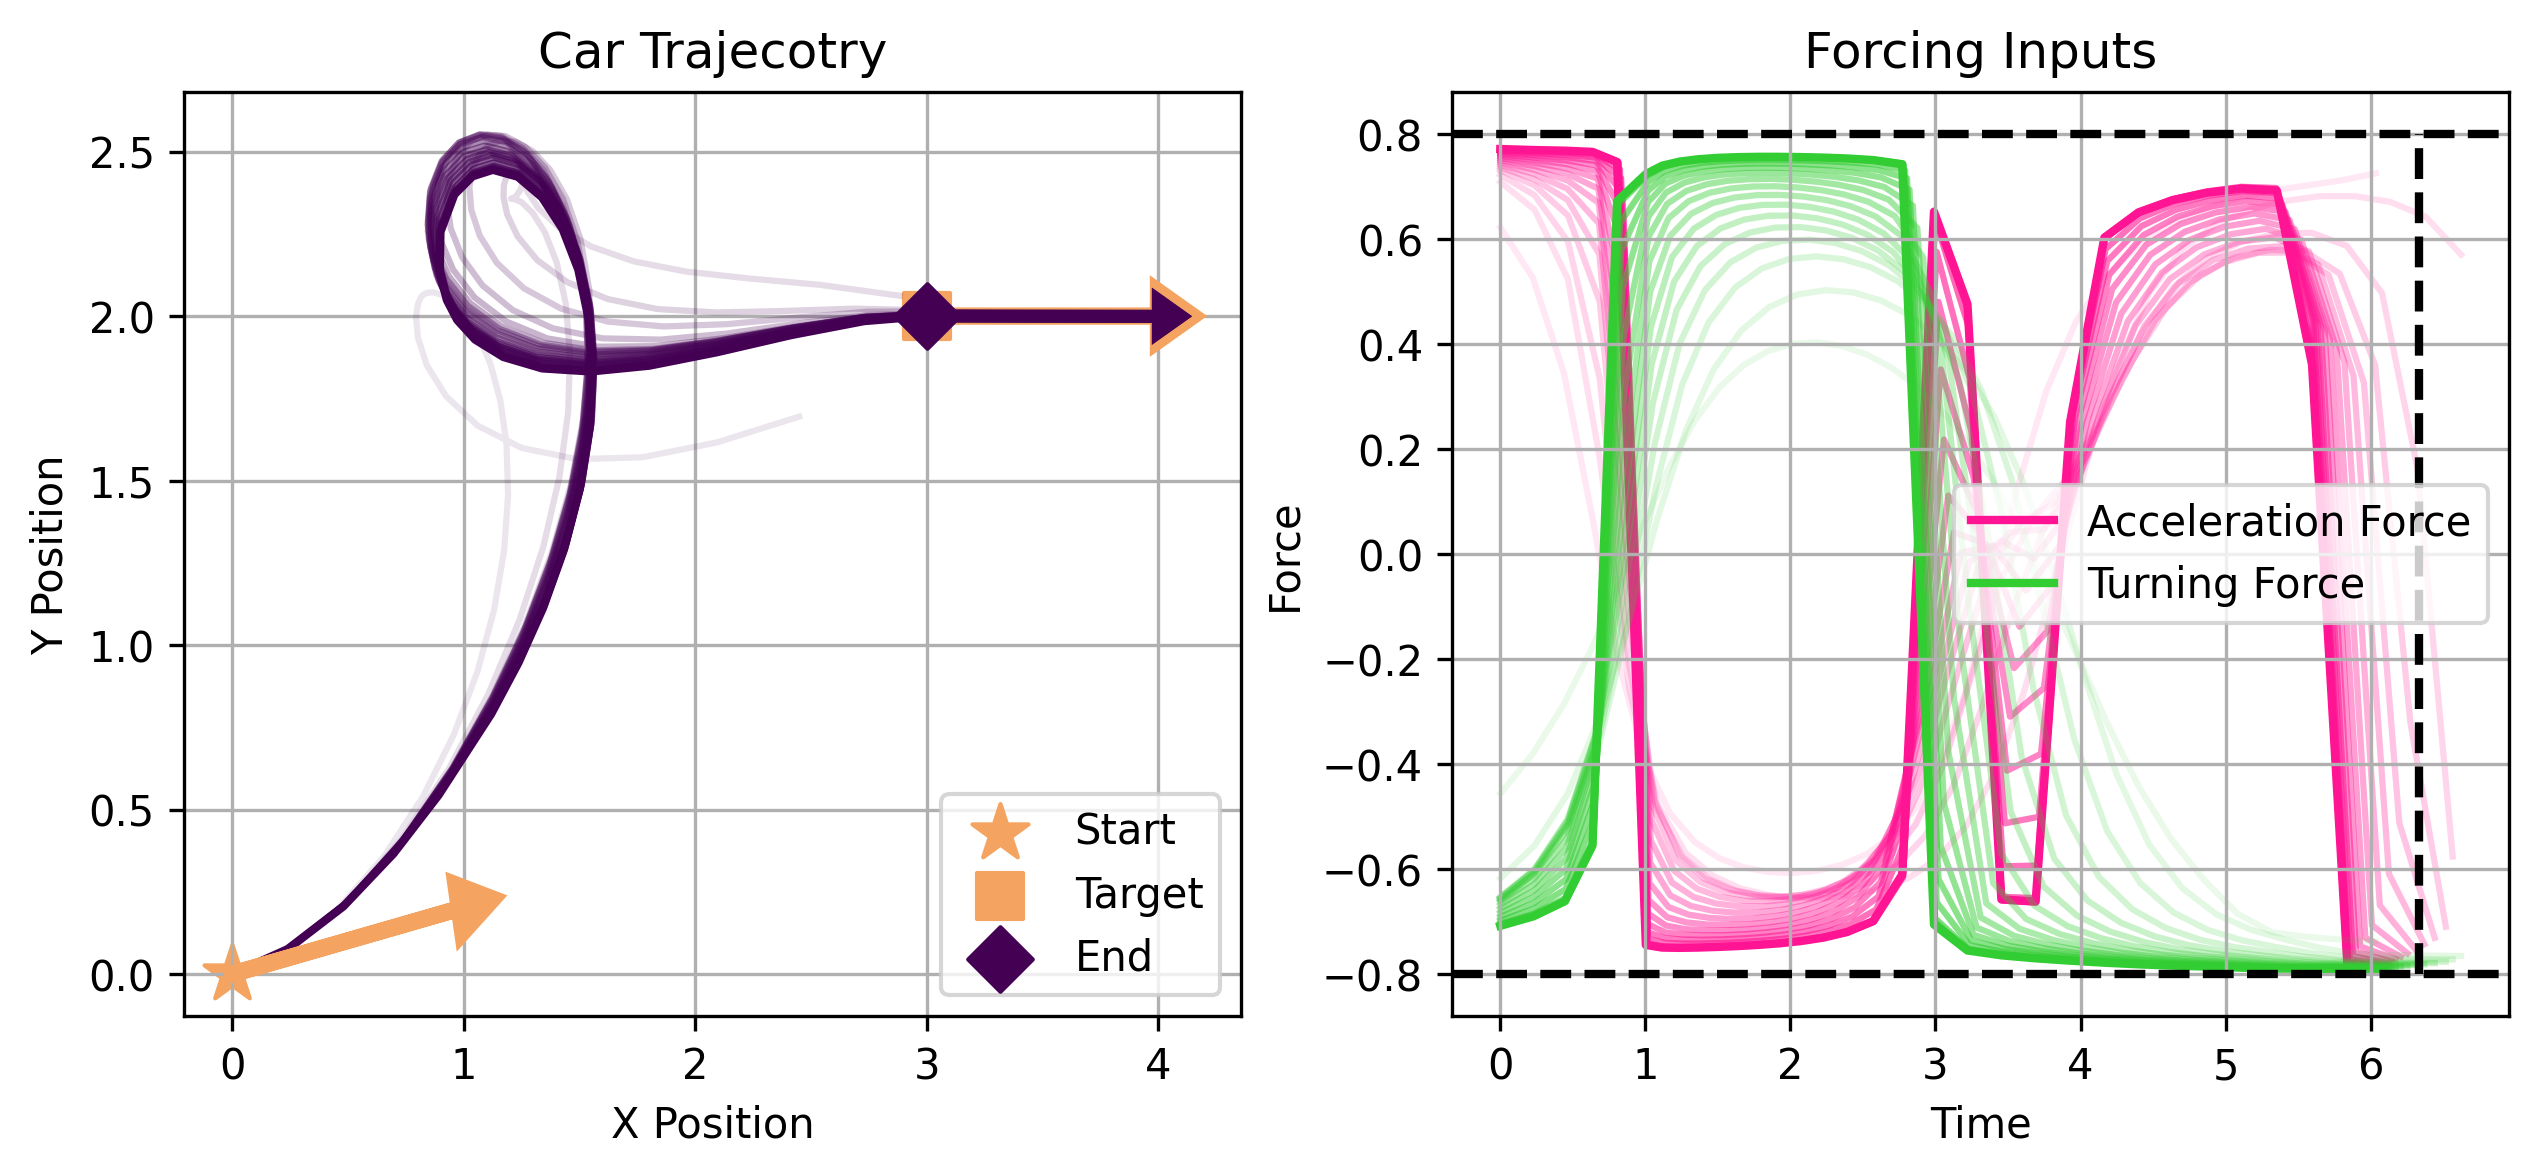

In [12]:
v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])

target = pt.tensor([3, 2, 0,1,-0.5])
n_steps = pt.tensor([32])

F_logits = [nn.Parameter(pt.zeros(n_steps[i], 3)) for i in range(n_steps.shape[0])]

print(f'Start: {v0.detach()}\n' +
      f'Target: {target}\n'
    )

pt.autograd.set_detect_anomaly(False)

F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs = optimizeMultiPath(v0, target, F_logits, iters=1000, fine_tuning_steps=250)

ts_cat = cat_ts(ts_mat)
F_cat = cat_F(F_true)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=300)


plot_multi_traj(V_mat, target, ax=ax1)
plot_multi_forcing(F_cat, ts_cat, n_steps, ax=ax2)
plt.show()

### Following a path (sine wave with 7 checkpoints)

In [13]:
v0 = pt.tensor([0, 0, np.pi/2, 0, 0, 0])

# sine
checkpoint_2d = pt.stack([pt.arange(np.pi/2, 4*np.pi, np.pi/2), pt.sin(pt.arange(np.pi/2, 4*np.pi, np.pi/2))], axis=1)

target = pt.tensor([4*np.pi, 0, np.pi/4, 0.5, 0.25])
n_steps = pt.tensor([32] + 7*[24])

checkpoint_dof_init = pt.tensor([[0, 0.25, -1],
                                 [-np.pi/4, 0.5, 0.5],
                                 [0, 0.25, 1],
                                 [np.pi/4, 0.5, -0.5],
                                 [0, 0.25, -1],
                                 [-np.pi/4, 0.5, -0.5],
                                 [0, 0.25, 1]])

checkpoint_dof = nn.Parameter(checkpoint_dof_init.clone())

F_logits = [nn.Parameter(pt.zeros(n_steps[i], 3)) for i in range(n_steps.shape[0])]

print(f'Start: {v0.detach()}\n' +
      f'Checkpoint Guess: {pt.cat([checkpoint_2d, checkpoint_dof.detach()], dim=1)}\n'+
      f'Target: {target}\n'
    )

F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs = optimizeMultiPath(v0, target, F_logits,
                                                                               checkpoint_2d=checkpoint_2d,
                                                                               checkpoint_dof=checkpoint_dof,
                                                                               #plot_freq=10,
                                                                               iters=500)

segment_start = pt.cat([checkpoint_2d, checkpoint_dof], dim=1)
segment_end = pt.tensor([V_mat[-1][i][-1:].tolist() for i in range(len(V_mat[-1])-1)]).squeeze(dim=1)

segment_diff = segment_start-segment_end

segment_diff[:,2] = angle_diff(segment_start[:,2], segment_end[:,2])

print(f'Position Differences:\n{segment_diff}')

Start: tensor([0.0000, 0.0000, 1.5708, 0.0000, 0.0000, 0.0000])
Checkpoint Guess: tensor([[ 1.5708e+00,  1.0000e+00,  0.0000e+00,  2.5000e-01, -1.0000e+00],
        [ 3.1416e+00, -8.7423e-08, -7.8540e-01,  5.0000e-01,  5.0000e-01],
        [ 4.7124e+00, -1.0000e+00,  0.0000e+00,  2.5000e-01,  1.0000e+00],
        [ 6.2832e+00,  1.7485e-07,  7.8540e-01,  5.0000e-01, -5.0000e-01],
        [ 7.8540e+00,  1.0000e+00,  0.0000e+00,  2.5000e-01, -1.0000e+00],
        [ 9.4248e+00, -2.3850e-08, -7.8540e-01,  5.0000e-01, -5.0000e-01],
        [ 1.0996e+01, -1.0000e+00,  0.0000e+00,  2.5000e-01,  1.0000e+00]])
Target: tensor([12.5664,  0.0000,  0.7854,  0.5000,  0.2500])

Iteration 50, Mean Position Dist: 0.150,  End Time: 17.968,  L2: 0.097,  Reverse Loss: 0.033
Iteration 100, Mean Position Dist: 0.080,  End Time: 17.025,  L2: 0.206,  Reverse Loss: 0.029
Iteration 150, Mean Position Dist: 0.085,  End Time: 15.924,  L2: 0.303,  Reverse Loss: 0.023
Iteration 200, Mean Position Dist: 0.087,  End T

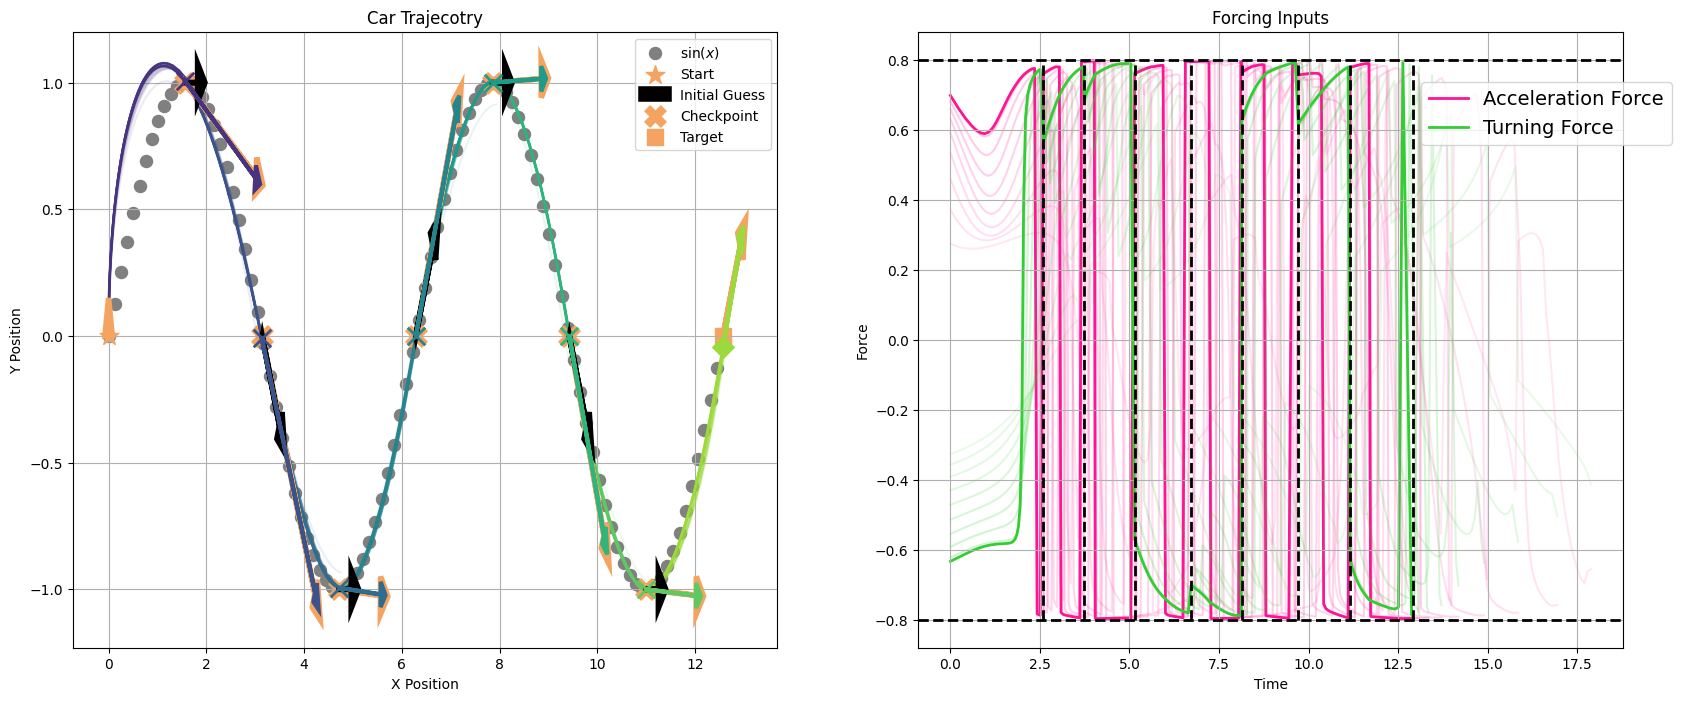

In [14]:
ts_cat = cat_ts(ts_mat)
F_cat = cat_F(F_true)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
#fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 16))

x=np.linspace(0,4*np.pi, 100)

ax1.scatter(x, np.sin(x), marker='.', s=300, color='grey', zorder=0, label=r'$\sin(x)$')

plot_multi_traj(V_mat, target, 
          checkpoint_2d=checkpoint_2d, checkpoint_dof=checkpoint_dof, 
          dof_init=checkpoint_dof_init, ax=ax1, vmin=0.15, vmax=0.85)

alphas = np.linspace(0.1, 0.25, num=len(ts_cat))
alphas[-1] = 1
plot_multi_forcing(F_cat, ts_cat, n_steps, ax=ax2, alphas=alphas)
ax2.legend(bbox_to_anchor=(0.7,0.8), fontsize=14)
plt.show()

# Plots for presentation

C:\Users\kenne\AppData\Local\Temp\ipykernel_41148\928677679.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  arrowDir = lambda V: (V[3]*np.cos(V[2]), V[3]*np.sin(V[2]))


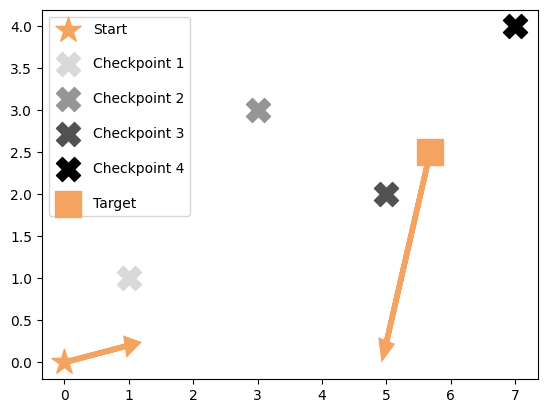

In [15]:
v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])

arrowDir = lambda V: (V[3]*np.cos(V[2]), V[3]*np.sin(V[2]))

plt.scatter(v0[0], v0[1], marker='*', color='sandybrown', s=360, label='Start')
plt.arrow(*v0[0:2], *arrowDir(v0), head_width=0.15, head_length=0.15, lw=4, color='sandybrown', zorder=6)

n_check = 5
colors = color_map(n_check, cmap_name='Greys')
ch = pt.tensor([[1,1],
                [3,3],
                [5,2],
                [7,4]])

for i in range(ch.shape[0]):
    plt.scatter(*ch[i], marker='X', s=300, color=colors[i+(n_check-ch.shape[0])], label=f'Checkpoint {i+1}')

plt.scatter(target[0], target[1], marker='s', color='sandybrown', s=360, label='Target')
plt.arrow(*target[0:2], *arrowDir(target), head_width=0.15, head_length=0.15, lw=4, color='sandybrown', zorder=6)
plt.legend(labelspacing=1.5)
plt.show()

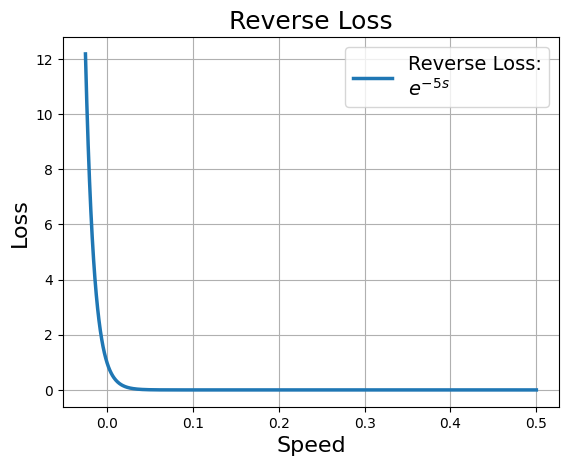

In [16]:
speeds = np.linspace(-0.025, 0.5, num=1000)
plt.plot(speeds, np.exp(-100*speeds), lw=2.5, label='Reverse Loss:\n' + r'$e^{-5s}$')
plt.grid()
plt.legend(fontsize=14)
plt.title('Reverse Loss', fontsize=18)
plt.xlabel('Speed', fontsize=16)
plt.ylabel('Loss', fontsize=16)
#plt.yscale('log')
plt.show()